In [1]:
import gcsfs
from scipy.io import loadmat
from scipy.signal import resample
from scipy.stats import zscore
import matplotlib.pyplot as plt
import os.path as op
import numpy as np
from neurodsp.filt.filter import filter_signal

In [2]:
fs = gcsfs.GCSFileSystem(project='learning-2-learn-221016')

In [3]:
path = 'learning2learn/Buffalo/wcst-nhp/SA/sess-20180918/ephys/'

In [4]:
data = np.empty((124, 11796177))

for chan in range(1, 125):
    fname = op.join(path, f'chan-{chan}', f'sub-SA_sess-20180918_chan-{chan}.mat')
    # print(f"Opening {fname}")
    with fs.open(fname) as f_chan:
        f_chan = loadmat(f_chan)
        data[chan-1] = f_chan['data'].squeeze()

In [5]:
data = resample(data, data.shape[-1]//10, axis=-1)

In [6]:
from picard import picard

In [7]:
def mixing(W, K):
    w = np.dot(W, K)
    return np.dot(w.T, np.linalg.inv(np.dot(w, w.T)))

In [8]:
n_components = 3
mean_corr = [0]
break_it = False

while not break_it:   
    K1, W1, Y1 = picard(data[:, :data.shape[-1]//2], n_components=n_components)
    K2, W2, Y2 = picard(data[:, data.shape[-1]//2:], n_components=n_components)
    mixing1 = mixing(W1, K1)
    mixing2 = mixing(W2, K2)
    
    corr = np.empty((mixing1.shape[-1], mixing2.shape[-1]))
    for ii in range(corr.shape[0]):
        for jj in range(corr.shape[1]):
            corr[ii, jj] = np.abs(np.corrcoef(mixing1[:, ii], mixing2[:, jj])[0, 1])
    
    new_mixing2 = np.empty_like(mixing2)
    max_corr = np.zeros(mixing1.shape[-1])
    for it in range(mixing1.shape[-1]):
        max_corr[it] = np.nanmax(corr)
        idx = np.where(corr == max_corr[it])
        new_mixing2[:, idx[0]] = mixing2[:, idx[1]]
        corr[idx[0], :] = np.nan
        corr[:, idx[1]] = np.nan
   
    this_mean_corr = np.mean(max_corr)
    if this_mean_corr < mean_corr[-1] and (mean_corr[-1] - this_mean_corr) > 0.05 * mean_corr[-1]:
        mean_corr.append(this_mean_corr)
        break_it = True
    else:
        mean_corr.append(this_mean_corr)
    n_components = n_components + 1

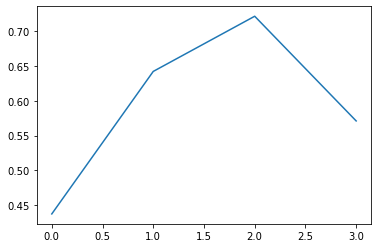

In [9]:
plt.plot(mean_corr[1:])

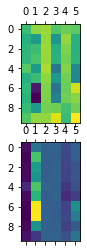

In [10]:
fig, ax = plt.subplots(2)
ax[0].matshow(new_mixing2[:10])
ax[1].matshow(mixing1[:10])

In [ ]:
# Another approach might be to rely on the fact that:
# Y = WKX 
# To derive a cross-validated prediction of Y
